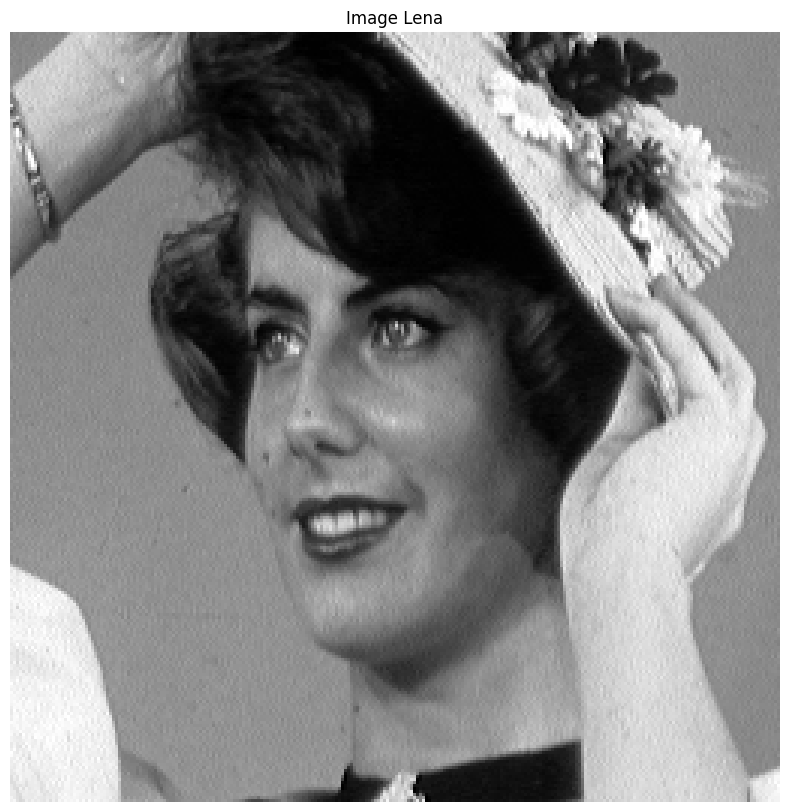

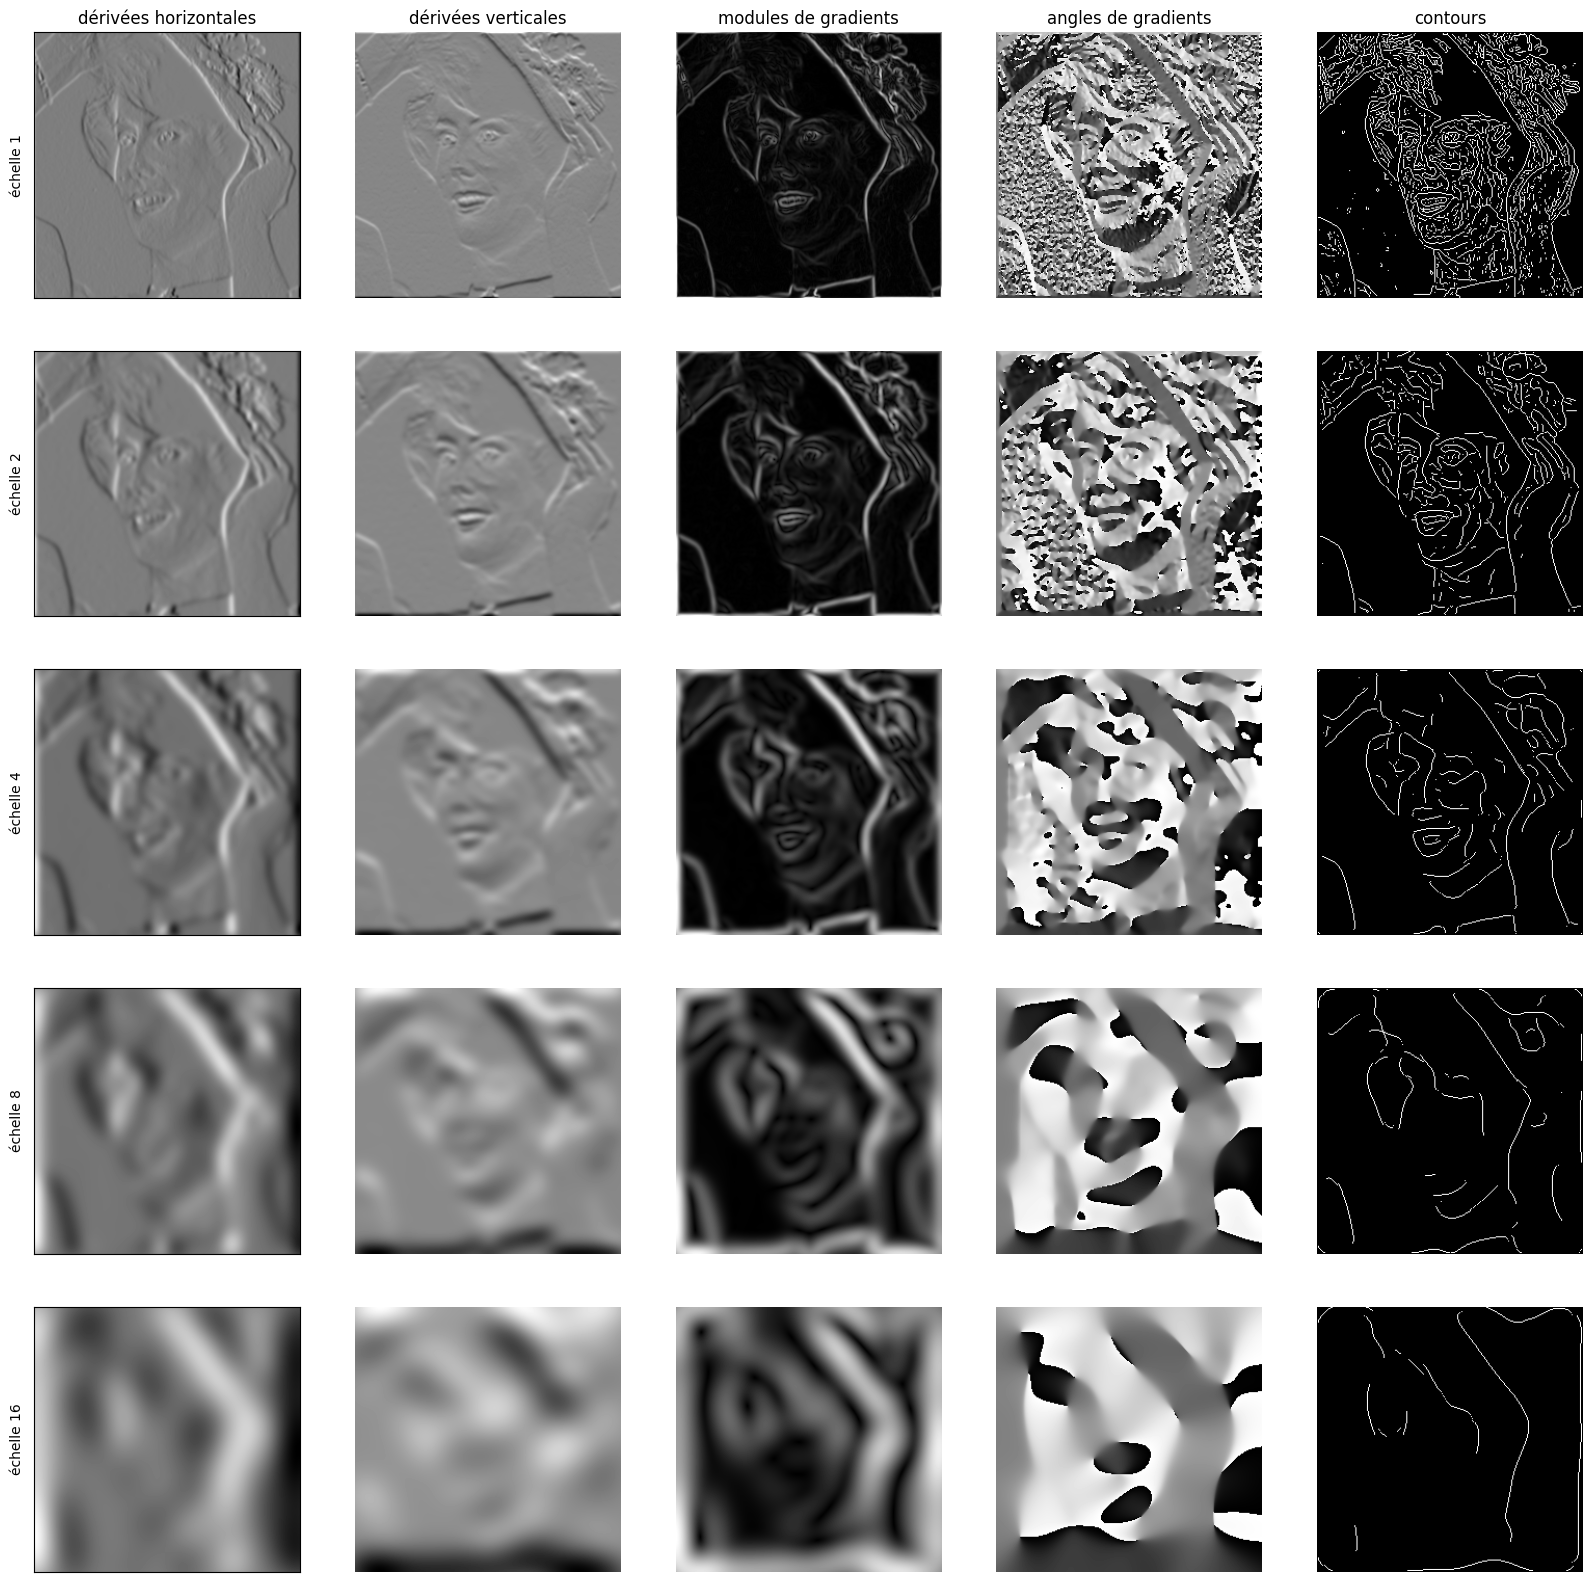

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def detection(im, sigma, scale, seuil) :
    sigma_scaled = sigma*scale
    fsize = int(3*sigma_scaled+0.5)
    fx = np.arange(1,fsize+1)
    fx = np.concatenate((-fx[::-1],[0],fx))
    gauss = np.exp(-0.5*(fx/sigma_scaled)**2)/(np.sqrt(2*np.pi)*sigma_scaled)
    dgauss = -gauss*(fx/(sigma_scaled**2))
    fil_dx = np.outer(gauss,dgauss)
    fil_dy = np.outer(dgauss,gauss)
    dx = signal.fftconvolve(im, fil_dx,'same')
    dy = signal.fftconvolve(im, fil_dy,'same')
    angles = np.arctan2(dy,dx)
    grad_module = np.sqrt(dx**2 + dy**2)
    if (seuil>0.0) & (seuil<1.0) :
        cs = np.sort(grad_module, axis = None)
        ind = int(len(cs)*(1-seuil))
        ind = min(ind, len(cs))
        grad_min = cs[ind]
    else:
        grad_min = 0
    gradx_plus = np.copy(grad_module)
    gradx_moins = np.copy(grad_module)
    gradx_plus[:,0:-1] = grad_module[:,1::]
    gradx_moins[:,1::] = grad_module[:,0:-1]
    c1 = np.logical_and(angles >= (-np.pi/4), angles <= (np.pi/4))
    c2 = np.logical_or(angles >= (3*np.pi/4), angles <= - (3*np.pi/4))
    cv = np.logical_or(c1,c2)
    ch = np.logical_not(cv)
    edge_vert  = np.logical_and(cv, grad_module > gradx_plus)
    edge_vert = np.logical_and(edge_vert, grad_module > gradx_moins)
    edge_vert  = np.logical_and(edge_vert, grad_module >= grad_min)
    grady_plus = np.copy(grad_module)
    grady_moins = np.copy(grad_module)
    grady_plus[0:-1,:] = grad_module[1::,:]
    grady_moins[1::, :] = grad_module[0:-1, :]
    edge_hori  = np.logical_and(ch, grad_module > grady_plus)
    edge_hori = np.logical_and(edge_hori, grad_module > grady_moins)
    edge_hori  = np.logical_and(edge_hori, grad_module >= grad_min)
    edge = np.logical_or(edge_vert, edge_hori)
    return edge, grad_module, angles, dx, dy
    

figw=10
figh=10
figw2=20#15
figh2=20#20
seuil = 0.50
im = plt.imread('FEMME.TIF').astype(np.float32)
plt.figure(figsize=(figw,figh))
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.title('Image Lena')
plt.axis(False)
plt.show()

sigma = 1
maxnbscales = 5
nl,nc = im.shape
log2s = min(np.log2(nl), np.log2(nc))
log2s = min(int(log2s),maxnbscales)
fig, axs = plt.subplots(log2s, 5, figsize=[figw2,figh2])
for k in range(log2s):
    scale = 2**k
    edge, grad_module, angles, dx, dy = detection(im, sigma, scale, seuil)
    axs[k,0].imshow(dx, cmap='gray',vmin=dx.min(), vmax=dx.max())
    if(k==0):
        axs[k,0].set_title('dérivées horizontales')
    axs[k,0].set_ylabel(f'échelle {scale}')
    axs[k,0].set_xlabel('')
    axs[k,0].set_xticks([])
    axs[k,0].set_yticks([])
    
    axs[k,1].imshow(dy, cmap='gray', vmin=dy.min(), vmax=dy.max())
    if(k==0):
        axs[k,1].set_title('dérivées verticales')
    axs[k,1].axis(False)
    
    axs[k,2].imshow(grad_module, cmap='gray', vmin=0, vmax=grad_module.max())
    if(k==0):
        axs[k,2].set_title('modules de gradients')
    axs[k,2].axis(False)
    
    axs[k,3].imshow(angles, cmap='gray', vmin=-np.pi, vmax=np.pi)
    if(k==0):
        axs[k,3].set_title('angles de gradients')
    axs[k,3].axis(False)
    
    axs[k,4].imshow(edge, cmap='gray', vmin=0, vmax=1)
    if(k==0):
        axs[k,4].set_title('contours')
    axs[k,4].axis(False)
plt.show()